# Projet de système de recommandation
Module Data Mining - CPE Lyon 2023

*Auteurs : Hugo MARTA et Léo GONNET (4ETI)*

---


In [ ]:
# Importation des bibliothèques
import os
import numpy as np
import math
import pandas as pd
import json
import requests # requêtes http
import urllib.request # téléchargement d'images
import shutil # recursive rem
from time import sleep
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.cluster import KMeans
import datetime as dt
from uuid import uuid4 #générateur d'identifiant unique
import random as rd

## **1.** Collecte de données

On va récupérer les images sur Wikimedia Commons à l'aide de son API.
On utilise la bibliothèque requests pour faire les requêtes HTTP.

⚠️ À chaque execution on écrase le dossier d'image !

In [ ]:
# Nombre d'images à télécharger maximum
NB_IMG_MAX = 200

# Mots-clés des thèmes à rechercher
KEYWORDS = ["Car","Cat"]

# Chemins
images_path = './images/'
bdd_path = './bdd.csv'

# Remise à zéro des données (Suppression de toutes les images déjà téléchargées et de la BDD)
if os.path.exists(images_path):
  shutil.rmtree(images_path)
os.makedirs(images_path)
if os.path.isfile(bdd_path):
  os.remove(bdd_path)

#On initialise le dataframe de la base de données
bdd_df = pd.DataFrame({'ID':[],'sha1':[],'annee':[],'largeur':[],'hauteur':[]})
bdd_df['ID'] = bdd_df['ID'].astype(int)
bdd_df['annee'] = bdd_df['annee'].astype(int)
bdd_df['largeur'] = bdd_df['largeur'].astype(int)
bdd_df['hauteur'] = bdd_df['hauteur'].astype(int)


def recherche_wiki(keyword):
    # str keyword -> obj json results contenant les résultats
    # fonction intermédiaire de recherche
    
    # Paramétrage du header selon la User-Agent policy de Wikimedia Commons https://meta.wikimedia.org/wiki/User-Agent_policy
    # permet d'augmenter le taux de requêtes par seconde
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'GogoBot/1.0 (https://cpe.fr; leo.gonnet@cpe.fr)')]
    urllib.request.install_opener(opener)
    
    # URL de l'API de recherche de médias de Wikimedia Commons
    url_api = f"https://commons.wikimedia.org/w/api.php?action=query&generator=images&prop=imageinfo&gimlimit=500&redirects=1&titles={keyword}&format=json&iiprop=timestamp|user|userid|comment|canonicaltitle|url|size|dimensions|sha1|mime|thumbmime|mediatype|bitdepth"

    # Envoyer la requête et obtenir la réponse
    response = requests.get(url_api)

    # Traiter la réponse
    data = json.loads(response.text)
    results = data["query"]["pages"]
    
    return results

nb_img = 0

for keyword in KEYWORDS :
    
    # requete
    results = recherche_wiki(keyword)
    nb_res = len(results)
    pages = list(results.items())
    
    i = 3 # premiers résultats pas exploitables

    # Parcours des résultats et enregistrements des informations
    while nb_img<NB_IMG_MAX and i < nb_res:
        page = pages[i]
        i += 1
        image = page[1]["imageinfo"][0]

        if image["mime"] == "image/jpeg": # Si l'image est au format jpeg
            #On convertit la date de l'image en timestamp pour récupérer l'année
            date_string=image["timestamp"]
            date_object=dt.datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%SZ')
            #On ajoute une ligne à la base de données
            new_row = pd.DataFrame({'ID': [nb_img], "sha1": [image["sha1"]], "annee": [date_object.year], "largeur": [image["width"]], "hauteur": [image["height"]], "url" : [image["url"]]})
            bdd_df = pd.concat([bdd_df, new_row], ignore_index=True)
            #On incrémente l'indice de l'image
            nb_img += 1

# Ecriture de la base de données dans un fichier 
bdd_df.to_csv(bdd_path, index=False)


# Téléchargement des images
img_dl = 0

for index, row in bdd_df.iterrows():
    # Récupérer les URL des images de la BDD et les télécharger
    path = images_path + row['sha1'] + '.jpg'
    urllib.request.urlretrieve(row['url'], path)
    img_dl += 1
    
    print(f'\rTéléchargement : {img_dl}/{nb_img}', end='')
    
print(f'\r{img_dl}/{len(bdd_df)} images ont été téléchargées')
bdd_df

200/200 images ont été téléchargées


,ID,sha1,annee,largeur,hauteur,url
0,0,ace42e2d7c42305f9ebb5786560c234610c47ec6,2010,3264,2176,https://upload.wikimedia.org/wikipedia/commons...
1,1,8225329ebd3e3860f47463a13f92daebbebfa989,2005,1683,1395,https://upload.wikimedia.org/wikipedia/commons...
2,2,d751ae9012a18dab35f5b3a846af9dd8ff0836db,2014,1700,741,https://upload.wikimedia.org/wikipedia/commons...
3,3,0fd0cf9c5dd1c4ffeb3c1f6495c9af35f5726207,2015,5198,2847,https://upload.wikimedia.org/wikipedia/commons...
4,4,5a1c017e4f755196b8145d49b06dc2b86e640e18,2008,1648,956,https://upload.wikimedia.org/wikipedia/commons...
...,...,...,...,...,...,...
195,195,71998bf569191451f6d2889511984458cfc32759,2008,800,528,https://upload.wikimedia.org/wikipedia/commons...
196,196,93bb72ac6035719cae7002407ba2a68686df5d7f,2009,961,688,https://upload.wikimedia.org/wikipedia/commons...
197,197,9400ecb7e9e0de4b23243df15cacbeb956f9c881,2008,754,725,https://upload.wikimedia.org/wikipedia/commons...
198,198,df3cdf374bf426fe568890d0aa050d8ec8408444,2008,641,481,https://upload.wikimedia.org/wikipedia/commons...


## **2.** Étiquetage et annotation

Nous avons déjà pu récupérer une partie des étiquettes pour nos images grâce à la base de données de wikimedia.

Nous ajoutons la couleur dominante de chaque image grâce à notre l'implémentation d'un algorithme de K-Means.

In [ ]:
def recup_couleur_1(image_path):
  imgfile = Image.open(image_path)
  width, height = imgfile.size
  image = imgfile.resize((width//10, height//10))
  numarray = np.array(image.getdata(), np.uint8)
  clusters = KMeans(n_clusters=4, n_init='auto')
  clusters.fit(numarray)
  
  # Trier les centres par fréquence décroissante
  counts = np.unique(clusters.labels_, return_counts=True)[1]
  sort_index = np.argsort(counts)[::-1]
  sorted_centers = clusters.cluster_centers_[sort_index]

  # Récupérer la couleur principale (premier centre trié)
  main_color = sorted_centers[0]
  return main_color.tolist()

bdd_df['couleur']=''

for index, row in bdd_df.iterrows():
  print(f'\rProgression : {index+1}/{len(bdd_df)}', end='')
  path =  'images/' + row['sha1'] + '.jpg'
  coul = recup_couleur_1(path)
  
  bdd_df.at[index,'couleur'] = coul
  
print('\n')


bdd_df.to_csv(bdd_path, index=False)

Progression : 200/200



## **3.** Analyses de données


In [ ]:
class Utilisateur():
  def __init__(self, name=None ):
    self.id = uuid4()
    self.name = name
    self.path = {
        'profil' : "./profils.json",
        'bdd' : "./bdd.csv"
    }
    self.likes = set()
  
  def like(self, image):
    self.likes.add(image)
  
  def dislike(self, image):
    self.dislikes.add(image)
  
  def enregistrer(self):
    #sauvergade un profil 
    ...
      
  def charger(self, path):
    #charge un profil précédemment enregistré
    ...
      
  def recommander(self):
    taille_int = {
      'petite' : 0,
      'moyenne' : 1,
      'grande' : 2
    }
    # Recommandation d'une image en fonction du profil utilisateur

    id_images_aimees = list(self.likes)

    # Charger les informations sur les photos dans la base de données
    bdd_df = pd.read_csv(self.path['bdd'])

    # Calculer la distance euclidienne entre les photos aimées et les photos de la base de données
    distances = []
    for ind in range(len(bdd_df)):
      row = bdd_df.loc[ind]
      couleur_image_float = eval(bdd_df.loc[ind, 'couleur'])
      couleur_image = np.array(couleur_image_float)
      annee_image = row['annee']
      taille_image = taille_int[row['taille']]
      distance = 0
      for id in id_images_aimees:
        couleur_image_aimee_float = eval(bdd_df.loc[id, 'couleur'])
        couleur_image_aimee = np.array(couleur_image_aimee_float)
        annee_image_aimee = bdd_df.loc[id,'annee']
        taille_image_aimee = taille_int[bdd_df.loc[id,'taille']]
        distance += np.linalg.norm(couleur_image - couleur_image_aimee)/100
        distance += abs(annee_image - annee_image_aimee)/2
        distance += abs(taille_image - taille_image_aimee)
      distances.append((row['ID'], distance))

    # Trier les photos par ordre de similarité
    distances.sort(key=lambda x: x[1])

    return distances[rd.randint(0, 4)][0]


## **4.** Visualisation des données

Text(0, 0.5, 'Nombre')

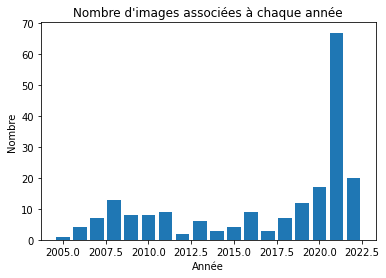

In [ ]:
#Liste contenant l'année de chaque image
annees=[]
#Lecture du fichier csv dans un dataframe
bdd_df=pd.read_csv('bdd.csv')
for ind,row in bdd_df.iterrows():
  annees.append(row["annee"])

#On compte le nombre de répétitions de chaque année
nbr_images_annee = [(i,annees.count(i)) for i in range(min(annees),max(annees)+1)]
##print(f'Nombre d\'images disponibles par année :{nbr_images_annee}')
#On affiche les données sous forme de graphique
plt.bar([x[0] for x in nbr_images_annee],[x[1] for x in nbr_images_annee])
plt.title("Nombre d'images associées à chaque année")
plt.xlabel("Année")
plt.ylabel("Nombre")

In [ ]:
#Initialisation des compteurs d'images
nbr_petites=0
nbr_moyennes=0
nbr_grandes=0
#Lecture du fichier csv dans un dataframe
bdd_df=pd.read_csv('bdd.csv')
#Ajout d'une nouvelle colonne vide 'taille'
bdd_df['taille']=''
#On parcourt les images pour compter les différentes tailles et les ajouter à la BDD
for ind,row in bdd_df.iterrows():
  taille_acc=''
  taille=(row["largeur"],row["hauteur"])
  if taille[0]<1280 or taille[1]<720:
    nbr_petites+=1
    taille_acc='petite'
  elif taille[0]<2560 or taille[1]<1440:
    nbr_moyennes+=1
    taille_acc='moyenne'
  else:
    nbr_grandes+=1
    taille_acc='grande'
  bdd_df.at[ind,'taille']=taille_acc
#On copie la BDD actualisée dans le fichier CSV
bdd_df.to_csv('bdd.csv', index=False)
#On affiche le nombre d'images par taille
affichage_tailles = {'Taille': ['Petites', 'Moyennes', 'Grandes'],'Nombre': [nbr_petites, nbr_moyennes, nbr_grandes]}
print(pd.DataFrame(affichage_tailles).to_string(index=False))

  Taille  Nombre
 Petites      30
Moyennes      40
 Grandes     130


## **5.** Visualisation des données

21


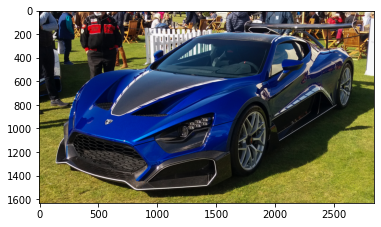

In [ ]:
user1 = Utilisateur('Toto')
user1.likes.update([4,65,34,21])
id_reco = user1.recommander()
print(id_reco)

path = f"images/{bdd_df.loc[id_reco, 'sha1']}.jpg"
image = img.imread(path)
plt.imshow(image)
plt.show()